# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [49]:
import os
import math
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

In [50]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '071302oci'  # Copy name from the model training file
exp = 't'

In [51]:
max_value = 2.5
min_value = -2.0

In [ ]:
model.load_state_dict(torch.load('./models/{}_min_valid_loss.pth'.format(expname)))
# model.load_state_dict(torch.load('/Users/xingyanli/Lab/gestar2_regression/liquid_ice/models/071303oci_77_min_valid_loss.pth'))

## Load data

In [52]:
X_train_t = torch.load(f'data/X_train_{exp}.pt')
y_train_t = torch.load(f'data/y_train_{exp}.pt')

X_val_t = torch.load(f'data/X_val_{exp}.pt')
y_val_t = torch.load(f'data/y_val_{exp}.pt')

X_test_t = torch.load(f'data/X_test_{exp}.pt')
y_test_t = torch.load(f'data/y_test_{exp}.pt')

# Network

In [53]:
class MultiTask(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 32),
      nn.ReLU(),
      nn.Linear(32, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      # nn.Linear(128, 1)
    )
    self.cls = nn.Sequential (
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 3),
      nn.Softmax()
    )
    self.reg = nn.Sequential (
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    feature = self.encoder(x)
    classification = self.cls(feature)
    regression = self.reg(feature)

    return classification, regression

## Load model

In [54]:
model = MultiTask(input_size=X_train_t.shape[1])
loss_cls = nn.CrossEntropyLoss()
loss_reg = nn.L1Loss()

<All keys matched successfully>

In [55]:

# Test data loader
dataset_test = Data.TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(dataset = dataset_test, batch_size = len(y_test_t), shuffle=False, pin_memory=True)

# Load model
test_loss = 0.0
test_num = 0
for step, (d_x,d_y) in enumerate(test_loader):
    output_cls_test, output_reg_test = model(d_x)
    output_reg_test = output_reg_test*(max_value-min_value)+min_value

    ground_truth_cls_test = torch.stack((d_y[:,0], d_y[:,1],d_y[:,2]), -1)
    ground_truth_reg_test = torch.reshape(d_y[:,3], [-1,1])

    ground_truth_reg_test = ground_truth_reg_test*(max_value-min_value)+min_value
    l_cls_t = loss_cls(output_cls_test, ground_truth_cls_test)
    l_reg_t = loss_reg(output_reg_test, ground_truth_reg_test)
    
    loss_t = 0.5*l_cls_t + 0.5*l_reg_t
    test_loss +=loss_t.item() * d_x.size(0)
    test_num += d_x.size(0)
print(f'Test CLS Loss: {l_cls_t:.3f}, Test REG Loss: {l_reg_t:.3f} \n') 
output_cls_test = output_cls_test.detach().cpu().numpy()
output_reg_test = output_reg_test.detach().cpu().numpy()
ground_truth_cls_test = ground_truth_cls_test.detach().cpu().numpy()
ground_truth_reg_test = ground_truth_reg_test.detach().cpu().numpy()
X_test_t = X_test_t.detach().cpu().numpy()

file = open("results/{}oci_log.txt".format(expname),"a")
file.write(f'Test CLS Loss: {l_cls_t:.3f}, Test REG Loss: {l_reg_t:.3f} \n') 


Test CLS Loss: 0.622, Test REG Loss: 0.180 



/Users/xingyanli/opt/anaconda3/envs/gestar2/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


44

## Evaluation of classifiction task

Evaluation metrics:
- Confusion matrix
- Accuracy
- Precision, Recall for each class

In [56]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [57]:
# # Threshold = 0.5 for classification
# output_cls_test = np.where(output_cls_test<=0.5, 0, output_cls_test)
# output_cls_test = np.where(output_cls_test>0.5, 1, output_cls_test)

In [58]:
# ground_truth_cls_test = np.where(ground_truth_cls_test<=0.5, 0, ground_truth_cls_test)
# ground_truth_cls_test = np.where(ground_truth_cls_test>0.5, 1, ground_truth_cls_test)

In [59]:
# Transfer 1hot array to 1-d array [0,1,2] for each label
y_pred = []
y_true = []
i=0
for i in range(len(ground_truth_cls_test)):
  y_true.append(np.argmax(ground_truth_cls_test[i]))
  y_pred.append(np.argmax(output_cls_test[i]))

In [60]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [61]:
# Load data for each surface type in albedo = [land, snow, desert, ocean_water]
y_pred_surface = []
y_true_surface = []
albedo_string = ['land', 'snow', 'desert', 'ocean_water']
for m in range(len(albedo_string)):
    y_pred_mth_surface = []
    y_true_mth_surface = []
    i = 0
    for i in range(len(X_test_t)):
        if X_test_t[i,226+m] == 1:
            y_pred_mth_surface.append(np.float(y_pred[i]))
            y_true_mth_surface.append(np.float(y_true[i]))
    y_pred_surface.append(y_pred_mth_surface)
    y_true_surface.append(y_true_mth_surface)

/var/folders/bk/np_scrln11196kgfc476_rpc0000gn/T/ipykernel_1066/3743206719.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred_mth_surface.append(np.float(y_pred[i]))
/var/folders/bk/np_scrln11196kgfc476_rpc0000gn/T/ipykernel_1066/3743206719.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_true_mth_surface.append(np.float(y_

In [62]:
# Transfer 1hot array to 1-d array for each label
y_pred_binary = np.where(y_pred==0, 0, 1)
y_true_binary = np.where(y_true==0, 0, 1)

### Metrics for (cloudy, cloud-free) binary classification
- Precision = TP/ (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 * (Precison * Recall / (Precision + Recall))
- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Confusion matrix

In [63]:
accuracy_bi = accuracy_score(y_true_binary, y_pred_binary)
f1_score_bi = f1_score(y_true_binary, y_pred_binary)
precision_bi = precision_score(y_true_binary, y_pred_binary)
recall_bi = recall_score(y_true_binary, y_pred_binary)

print(f'Accuracy - binary classification: {accuracy_bi: .3f}')
print(f'F1 - binary classification: {f1_score_bi: .3f}')
print(f'Recall - binary classification: {recall_bi: .3f}')
print(f'Precision - binary classification: {precision_bi: .3f}')


Accuracy - binary classification:  0.958
F1 - binary classification:  0.969
Recall - binary classification:  0.951
Precision - binary classification:  0.989


### Recall, accuracy, F1 score, precision for each label
- Precision = TP/ (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 * (Precison * Recall / (Precision + Recall))
- Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [64]:
# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy: .3f}')

Accuracy:  0.928


In [65]:
output_cls_test = np.where(output_cls_test<=0.5, 0, output_cls_test)
output_cls_test = np.where(output_cls_test>0.5, 1, output_cls_test)
ground_truth_cls_test = np.where(ground_truth_cls_test<=0.5, 0, ground_truth_cls_test)
ground_truth_cls_test = np.where(ground_truth_cls_test>0.5, 1, ground_truth_cls_test)

In [66]:
# Precision, Recall for each class
precision_0 = precision_score(ground_truth_cls_test[:,0], output_cls_test[:,0])
recall_0 = recall_score(ground_truth_cls_test[:,0], output_cls_test[:,0])

precision_1 = precision_score(ground_truth_cls_test[:,1], output_cls_test[:,1])
recall_1 = recall_score(ground_truth_cls_test[:,1], output_cls_test[:,1])

precision_2 = precision_score(ground_truth_cls_test[:,2], output_cls_test[:,2])
recall_2 = recall_score(ground_truth_cls_test[:,2], output_cls_test[:,2])

print(f'Recall - Cloud-free: {recall_0: .3f}')
print(f'Precision - Cloud-free: {precision_0: .3f}')

print(f'Recall - liquid: {recall_1: .3f}')
print(f'Precision - liquid: {precision_1: .3f}')

print(f'Recall - ice crystal: {recall_2: .3f}')
print(f'Precision - ice crystal: {precision_2: .3f}')

Recall - Cloud-free:  0.975
Precision - Cloud-free:  0.896
Recall - liquid:  0.903
Precision - liquid:  0.923
Recall - ice crystal:  0.912
Precision - ice crystal:  0.966


### Confusion matrix

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from pkg.cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [68]:
categories = ['Cloud-free', 'Liquid', 'Ice-crystal']

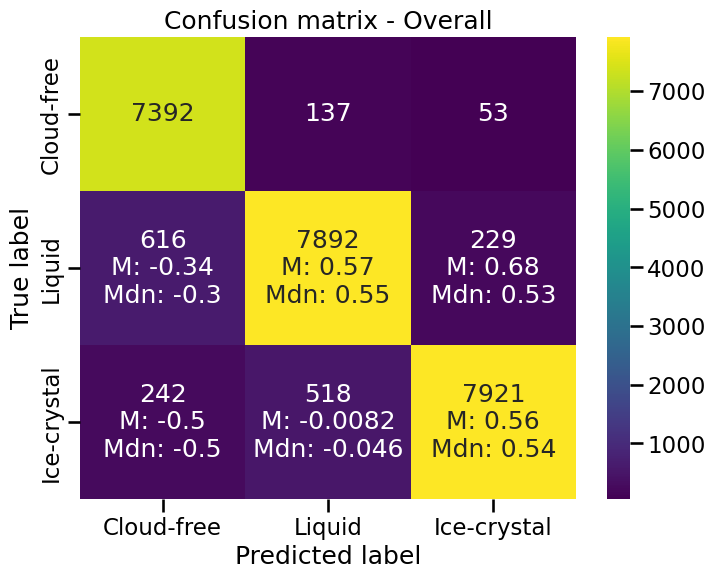

In [69]:
# True COT values for each block in the confusion matrix
y=[1,2]
x=[0,1,2]
cot_value = []
for i in y:
    for j in x:
        cot_value_current = ground_truth_reg_test[np.where((y_pred==j) & (y_true==i))]
        cot_value.append(cot_value_current)
        
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
make_confusion_matrix(confusion_matrix, cot_value, figsize=(8,6),group_names=False, categories=categories, COT_range=False, percent=False, title='Confusion matrix - Overall', sum_stats=False)
plt.savefig("./results/{}_confusionmatrix.png".format(expname))


### Confusion matrxi for each surface type
['land', 'snow', 'desert', 'ocean_water']

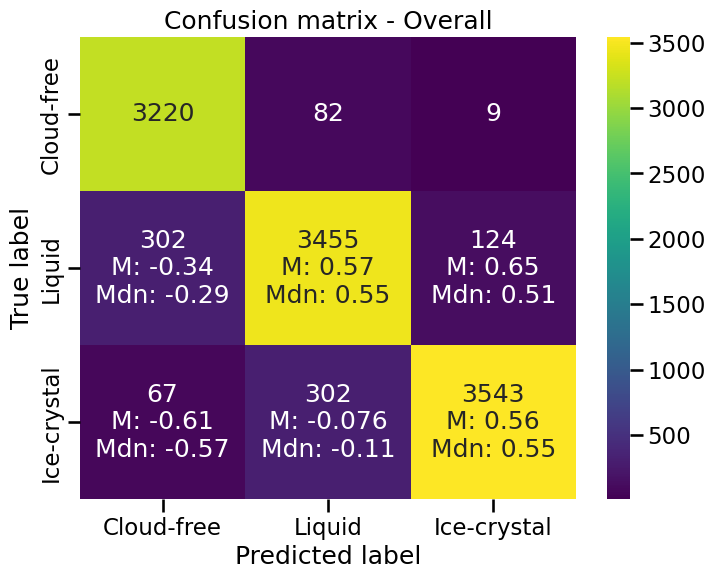

In [70]:
cot_value = []
for i in y:
    for j in x:
        cot_value_current = ground_truth_reg_test[np.where((y_pred==j) & (y_true==i) & (X_test_t[:,226]==1))]
        cot_value.append(cot_value_current)

confusion_matrix_land = metrics.confusion_matrix(y_true_surface[0], y_pred_surface[0])
make_confusion_matrix(confusion_matrix_land, cot_value, figsize=(8,6), group_names=False, categories=categories, COT_range=False, percent=False, title='Confusion matrix - Overall', sum_stats=False)
plt.savefig("./results/{}_confusionmatrix_land.png".format(expname))

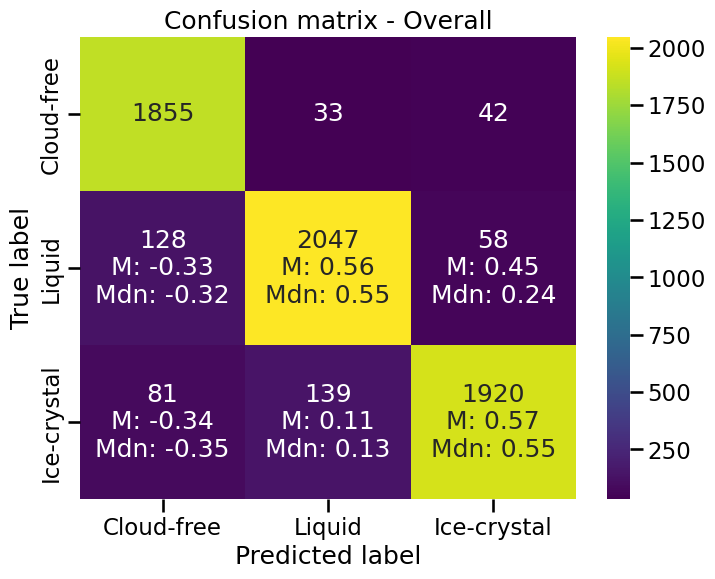

In [71]:
cot_value = []
for i in y:
    for j in x:
        cot_value_current = ground_truth_reg_test[np.where((y_pred==j) & (y_true==i) & (X_test_t[:,227]==1))]
        cot_value.append(cot_value_current)

confusion_matrix_snow = metrics.confusion_matrix(y_true_surface[1], y_pred_surface[1])
make_confusion_matrix(confusion_matrix_snow, cot_value, figsize=(8,6),group_names=False, categories=categories, COT_range=False, percent=False, title='Confusion matrix - Overall', sum_stats=False)
plt.savefig("./results/{}_confusionmatrix_snow.png".format(expname))

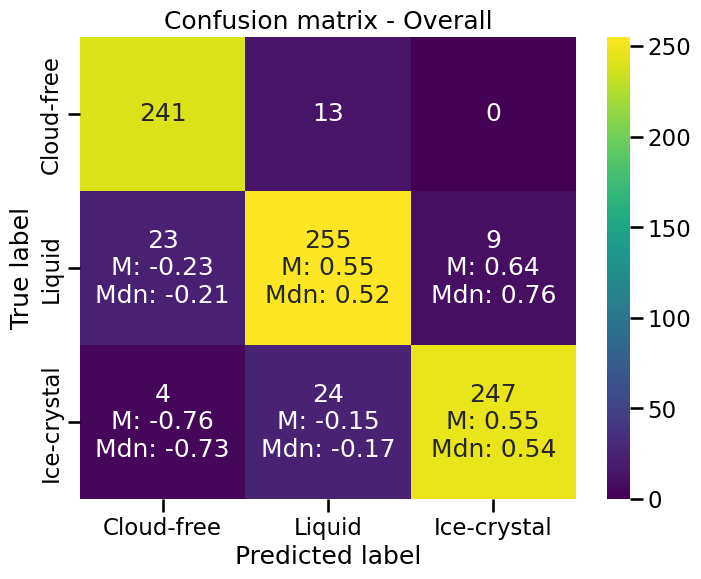

In [72]:
cot_value = []
for i in y:
    for j in x:
        cot_value_current = ground_truth_reg_test[np.where((y_pred==j) & (y_true==i) & (X_test_t[:,228]==1))]
        cot_value.append(cot_value_current)

confusion_matrix_desert = metrics.confusion_matrix(y_true_surface[2], y_pred_surface[2])
make_confusion_matrix(confusion_matrix_desert, cot_value, figsize=(8,6), group_names=False, categories=categories, COT_range=False, percent=False, title='Confusion matrix - Overall', sum_stats=False)
plt.savefig("./results/{}_confusionmatrix_desert.png".format(expname))

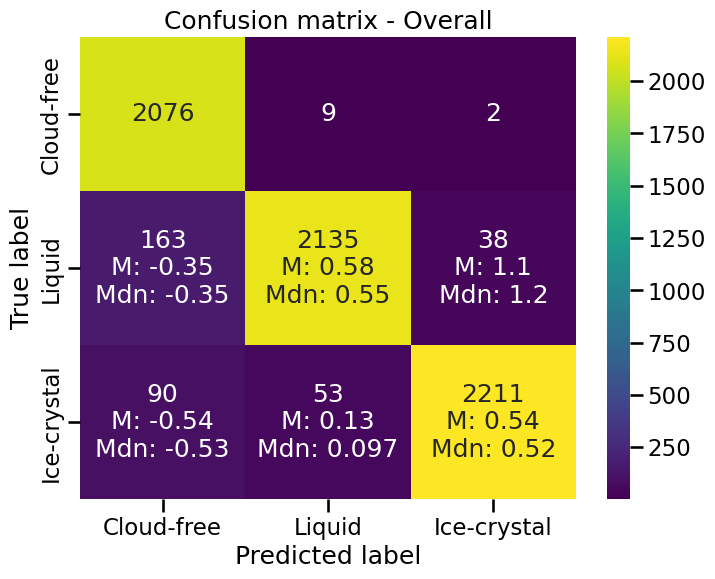

In [73]:
cot_value = []
for i in y:
    for j in x:
        cot_value_current = ground_truth_reg_test[np.where((y_pred==j) & (y_true==i) & (X_test_t[:,229]==1))]
        cot_value.append(cot_value_current)

confusion_matrix_ocean = metrics.confusion_matrix(y_true_surface[3], y_pred_surface[3])
make_confusion_matrix(confusion_matrix_ocean, cot_value, figsize=(8,6), group_names=False, categories=categories, COT_range=False, percent=False, title='Confusion matrix - Overall', sum_stats=False)
plt.savefig("./results/{}_confusionmatrix_ocean.png".format(expname))

### ROC

In [74]:
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
#     fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
#     roc_auc[i] = auc(fpr[i], tpr[i])

# print (roc_auc_score(y_true, y_pred))
# plt.figure()
# plt.plot(fpr[1], tpr[1])
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.show()

## Evaluation of regression task

Evaluation metrics:
- MSE, RMSE
- R-squared (coefficient of determination)
- Bins

In [75]:
from sklearn.metrics import r2_score

In [76]:
# Filter cloud-free pixels. Only evaluate over cloudy pixels
y_mask = np.where(y_true>=1, 1, 0)
y_mask = np.where(y_pred>=1, y_mask, 0)

### Overall regression results

In [77]:
# 
y_pred_reg = []
y_true_reg = []

for i in range(len(y_mask)):
    if y_mask[i]==1:
        y_pred_reg.append(output_reg_test[i])
        y_true_reg.append(ground_truth_reg_test[i])
y_pred_reg = np.array(y_pred_reg)
y_true_reg = np.array(y_true_reg)

In [78]:
MSE = np.square(np.subtract(y_true_reg,y_pred_reg)).mean()
RMSE = math.sqrt(MSE)
r2 = r2_score(y_true_reg, y_pred_reg)
file.write(f'MSE: {MSE: .3F}, RMSE: {RMSE: .3f}, R2: {r2: .3f} \n') 
print(f'MSE: {MSE: .3F}, RMSE: {RMSE: .3f} \n')
print(f'R2 score: {r2: .3F} \n')

MSE:  0.056, RMSE:  0.238 

R2 score:  0.743 



### Regression results for each label

In [79]:
# Load COT data for each label in [cloud-free, liquid, ice crystal]
y_pred_reg_liquid = []
y_true_reg_liquid = []
y_pred_reg_ice = []
y_true_reg_ice = []

for i in range(len(output_reg_test)):
    if y_mask[i] == 1:
        if y_true[i] == 1:
            y_pred_reg_liquid.append(output_reg_test[i])
            y_true_reg_liquid.append(ground_truth_reg_test[i])
        if y_true[i] == 2:
            y_pred_reg_ice.append(output_reg_test[i])
            y_true_reg_ice.append(ground_truth_reg_test[i])

In [80]:
MSE_liquid = np.square(np.subtract(np.array(y_true_reg_liquid),np.array(y_pred_reg_liquid))).mean()
RMSE_liquid = math.sqrt(MSE_liquid)
r2_liquid = r2_score(np.array(y_true_reg_liquid), np.array(y_pred_reg_liquid))
print('Liquid:')
file.write(f'MSE: {MSE_liquid: .3F}, RMSE: {RMSE_liquid: .3f}, R2: {RMSE_liquid: .3f} \n') 
print(f'MSE: {MSE_liquid: .3F}, RMSE: {RMSE_liquid: .3f}')
print(f'R2 score: {r2_liquid: .3F} \n')

MSE_ice = np.square(np.subtract(np.array(y_true_reg_ice),np.array(y_pred_reg_ice))).mean()
RMSE_ice = math.sqrt(MSE_ice)
r2_ice = r2_score(np.array(y_true_reg_ice), np.array(y_pred_reg_ice))
print('Ice:')
file.write(f'MSE: {MSE_ice: .3F}, RMSE: {RMSE_ice: .3f}, R2: {r2_ice: .3f} \n') 
print(f'MSE: {MSE_ice: .3F}, RMSE: {RMSE_ice: .3f} ')
print(f'R2 score: {r2_ice: .3F} \n')

Liquid:
MSE:  0.061, RMSE:  0.246
R2 score:  0.715 

Ice:
MSE:  0.052, RMSE:  0.229 
R2 score:  0.768 



### Regression results for each surface type

In [81]:
y_pred_reg_surface = []
y_true_reg_surface = []
for m in range(len(albedo_string)):
    y_pred_reg_surface.append(output_reg_test[np.where((y_mask==1)&((X_test_t[:,226+m]==1)))])
    y_true_reg_surface.append(ground_truth_reg_test[np.where((y_mask==1)&(X_test_t[:,226+m]==1))])

In [82]:
for i in range(len(albedo_string)):
    MSE_surface = np.square(np.subtract(y_true_reg_surface[i], y_pred_reg_surface[i])).mean()
    RMSE_ice = math.sqrt(MSE_surface)
    r2_ice = r2_score(y_true_reg_surface[i], y_pred_reg_surface[i])
    print(f'{albedo_string[i]}:')
    print(f'MSE: {MSE_surface: .3f}, RMSE: {RMSE_ice: .3f}, R2: {r2_ice: .3f} \n')
    file.write(f'MSE: {MSE_surface: .3f}, RMSE: {RMSE_ice: .3f}, R2: {r2_ice: .3f} \n') 

land:
MSE:  0.046, RMSE:  0.215, R2:  0.787 

snow:
MSE:  0.081, RMSE:  0.284, R2:  0.636 

desert:
MSE:  0.087, RMSE:  0.294, R2:  0.657 

ocean_water:
MSE:  0.047, RMSE:  0.217, R2:  0.785 



### Bins of R-2 and Accuracy
Bins divided by [thin, moderate, thick] or TRUE COT values [-1.5~0, 0~1, 1~2.5]

In [83]:
# Divided the regression outputs and classification outputs by bins
bin_category = ['thin', 'moderate', 'thick']
bin_division = [-1.5, 0, 1, 2.5]
y_true_bins = []
y_pred_bins = []
y_true_reg_bins = []
y_pred_reg_bins = []
# Classification predictions and true values
for i in range(len(bin_category)):
    y_true_bins.append(y_true[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1]))])
    y_pred_bins.append(y_pred[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1]))])
    y_true_reg_bins.append(ground_truth_reg_test[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1])&(y_pred>0))])
    y_pred_reg_bins.append(output_reg_test[np.where((np.reshape(ground_truth_reg_test, -1)>=bin_division[i])&(np.reshape(ground_truth_reg_test, -1)<bin_division[i+1])&(y_pred>0))])

In [84]:
# Calculate accuracy for each bin
accuracy_bins = []
r2_bins = []
for i in range(len(bin_category)): 
    accuracy_bins.append(accuracy_score(y_true_bins[i], y_pred_bins[i]))
    r2_bins.append(r2_score(y_true_reg_bins[i], y_pred_reg_bins[i]))
print(accuracy_bins, r2_bins)

[0.5950234403173459, 0.9675023212627669, 0.9653323802716226] [-3.239320802135069, 0.454099325322573, -0.6924106667335019]


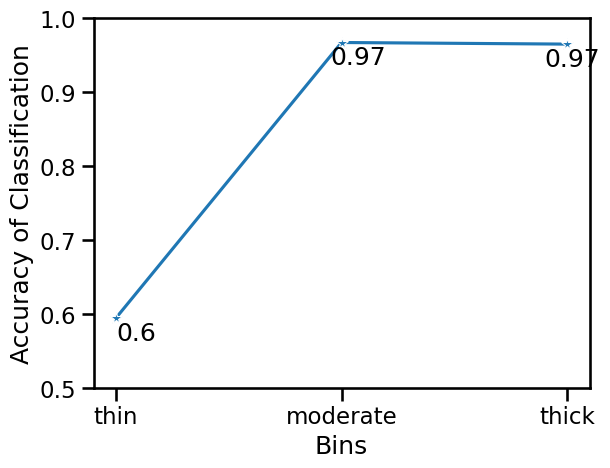

In [85]:
g = sns.lineplot(x=bin_category, y=accuracy_bins, marker='*')
g.set_ylim(0.5, 1)
g.set(xlabel='Bins', ylabel='Accuracy of Classification')
i=0
# label points on the plot
for x, y in zip(bin_category, accuracy_bins):
    plt.text(x = i*0.19, y = y-0.03, s = '{:.2}'.format(y))
    i=i+5
plt.savefig("./results/{}_binaccu.png".format(expname),bbox_inches = 'tight')

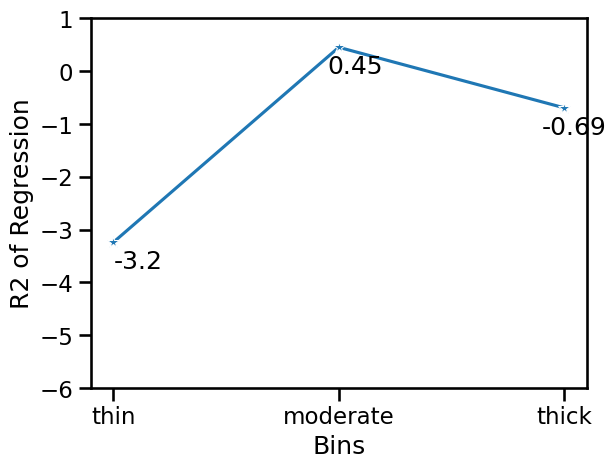

In [86]:
g = sns.lineplot(x=bin_category, y=r2_bins, marker='*')
g.set_ylim(-6, 1)
g.set(xlabel='Bins', ylabel='R2 of Regression')
i=0
# label points on the plot
for x, y in zip(bin_category, r2_bins):
    plt.text(x = i*0.19, y = y-0.5, s = '{:.2}'.format(y))
    i=i+5
plt.savefig("./results/{}_binr2.png".format(expname),bbox_inches = 'tight')

### Scatter plot

In [87]:
import pandas as pd

sns.set_context('notebook')

In [88]:
cot_each_label = y_true[np.where((y_true>0)&(y_pred>0))]
cot_each_label = np.where(cot_each_label==1, 'Liquid', 'Ice_crystal')
cot_each_label = np.array(cot_each_label,dtype='object')

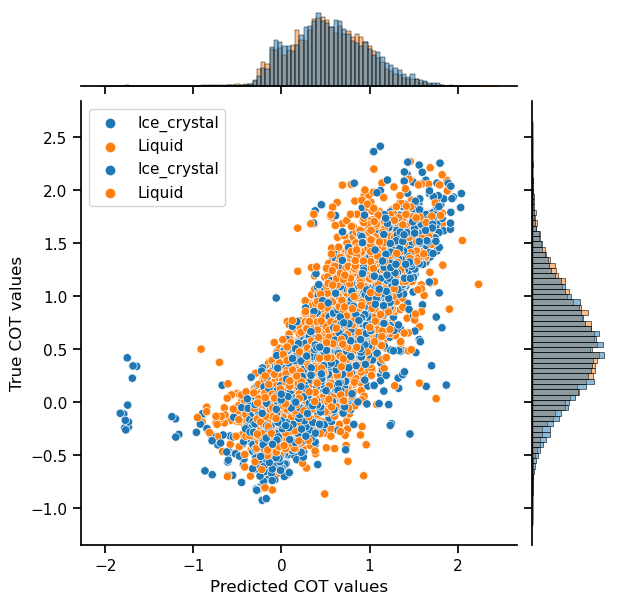

In [89]:
g = sns.jointplot(x=np.reshape(y_pred_reg,-1), y=np.reshape(y_true_reg,-1), hue=cot_each_label)
g.set_axis_labels('Predicted COT values', 'True COT values')
g.plot(sns.scatterplot, sns.histplot)
plt.savefig("./results/{}_scatter.png".format(expname),bbox_inches = 'tight')

### Hexbin plot

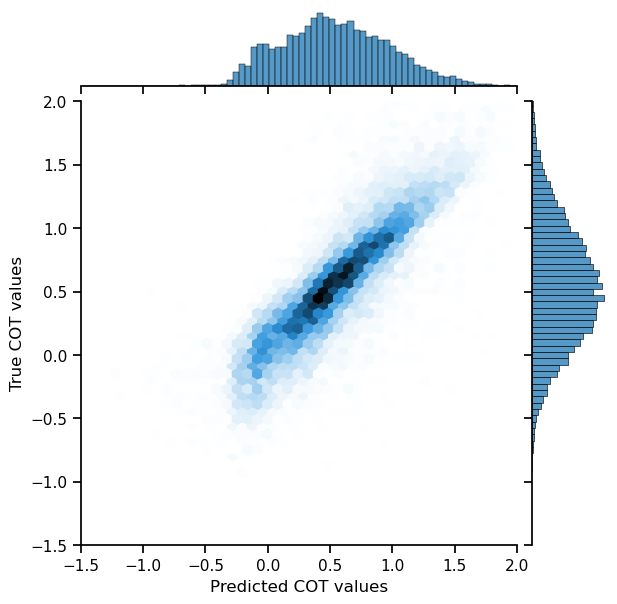

In [90]:
g = sns.jointplot(x=np.reshape(y_pred_reg,-1), y=np.reshape(y_true_reg,-1), kind="hex")
g.set_axis_labels('Predicted COT values', 'True COT values')
g.ax_marg_x.set_xlim(-1.5, 2)
g.ax_marg_y.set_ylim(-1.5, 2)
plt.savefig("./results/{}_hexbin.png".format(expname), bbox_inches = 'tight')